In [1]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from alg.vcl_net import MultiHeadVCLSplitMNIST
from alg.kcenter import KCenter

In [2]:
ds_test = datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=True)
ds_train = datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
def get_sMNIST(task_idx, device):
    np.random.seed(task_idx)
    labels = np.array_split(range(0, 10), 5)[task_idx]
    ds_train_filtered = list(filter(lambda item: item[1] in labels, ds_train))
    ds_test_filtered = list(filter(lambda item: item[1] in labels, ds_test))
    train_x = nn.Flatten()(torch.cat([d[0] for d in ds_train_filtered]))
    train_y = torch.tensor([d[1] - task_idx * 2 for d in ds_train_filtered])
    
    test_x = nn.Flatten()(torch.cat([d[0] for d in ds_test_filtered]))
    test_y = torch.tensor([d[1] - task_idx * 2 for d in ds_test_filtered])

    return train_x.to(device), train_y.to(device), test_x.to(device), test_y.to(device)

In [3]:
device = 'cuda'

test_x_all = []
test_y_all = []
test_task_i_all = []

coreset_x = None
coreset_y = None
coreset_size = 40

batch_size = 1024 # TODO: "batch size equal to the size of the training set"

random_coreset = True
accuracies = []
n_epochs = 200

# plot_heads_weights(VCL_split_MNIST(random_initialize=True, num_heads=2), VCL_split_MNIST(random_initialize=False, num_heads=2))
previous_model, coreset_task_mask = None, None

100%|██████████| 200/200 [00:07<00:00, 25.56it/s]


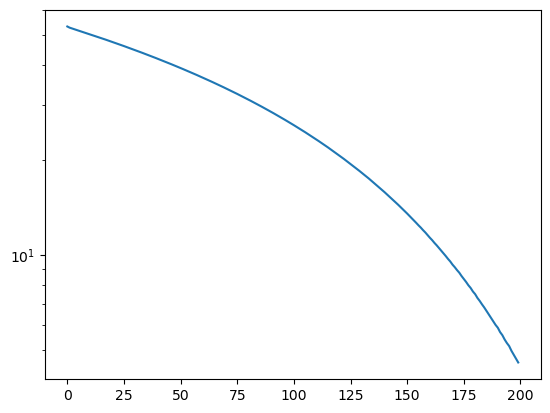

Accuracy by the propagation model is 1.0000


100%|██████████| 200/200 [00:00<00:00, 290.64it/s]


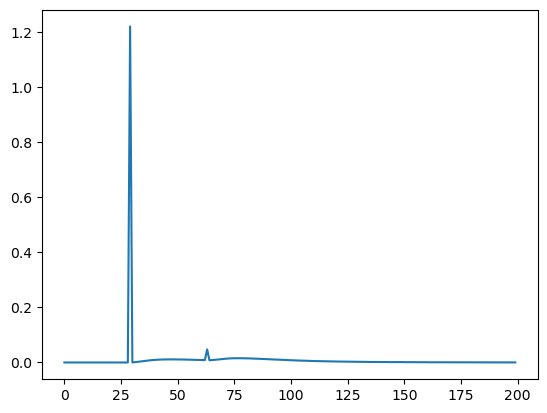

Task 0, Accuracy: 1.0000


100%|██████████| 200/200 [00:08<00:00, 24.29it/s]


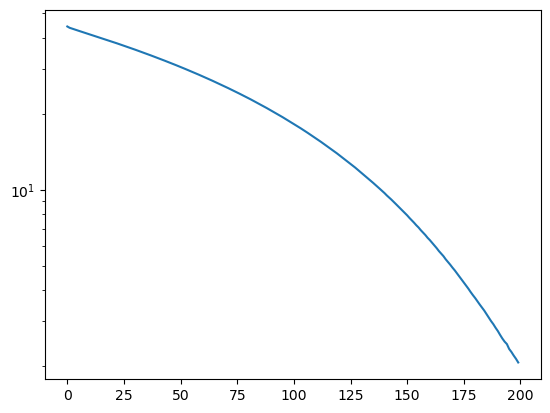

Accuracy by the propagation model is 0.9969


100%|██████████| 200/200 [00:00<00:00, 230.80it/s]


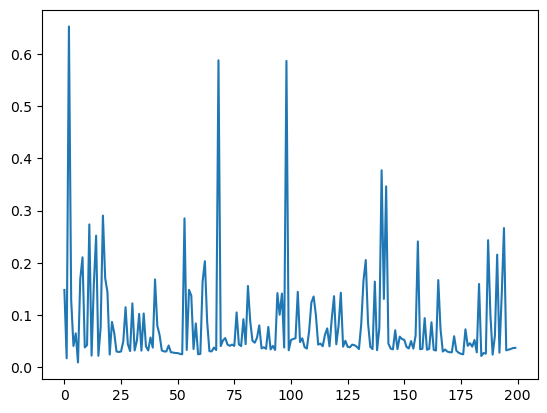

Task 1, Accuracy: 0.9976


100%|██████████| 200/200 [00:08<00:00, 23.59it/s]


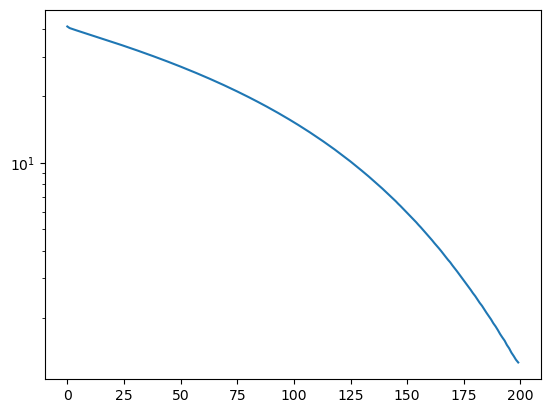

Accuracy by the propagation model is 0.9531


100%|██████████| 200/200 [00:01<00:00, 190.53it/s]


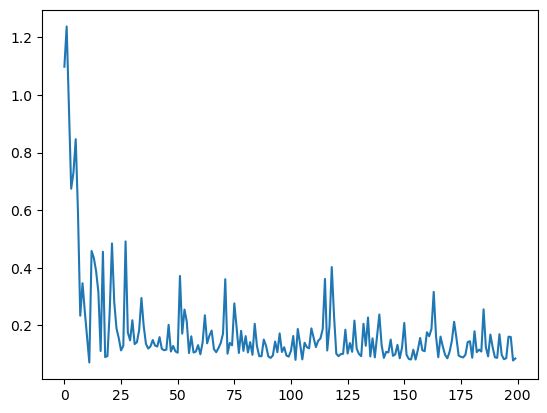

Task 2, Accuracy: 0.9929


100%|██████████| 200/200 [00:10<00:00, 19.87it/s]


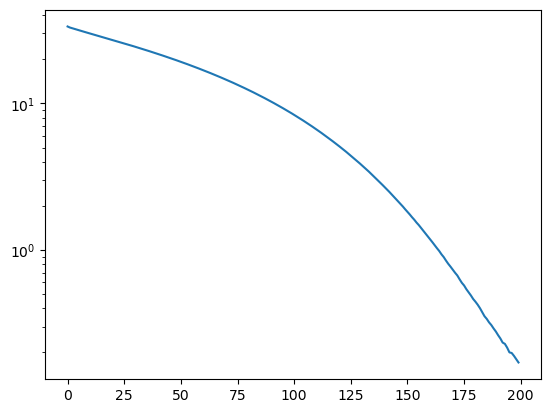

Accuracy by the propagation model is 0.9154


100%|██████████| 200/200 [00:01<00:00, 155.85it/s]


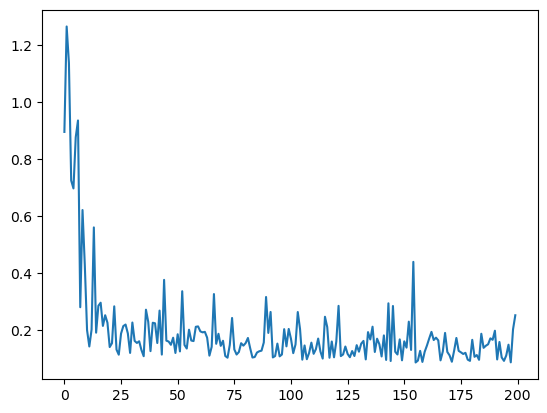

Task 3, Accuracy: 0.9925


100%|██████████| 200/200 [00:10<00:00, 18.59it/s]


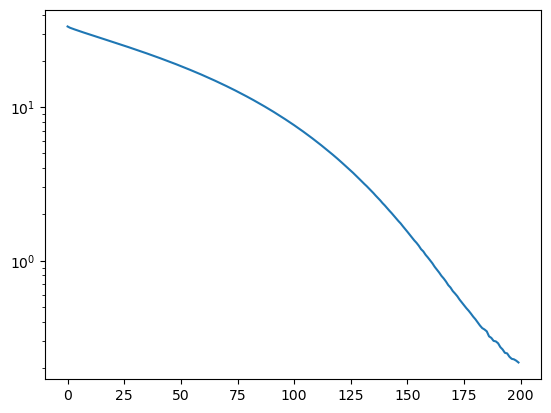

Accuracy by the propagation model is 0.9419


100%|██████████| 200/200 [00:01<00:00, 127.30it/s]


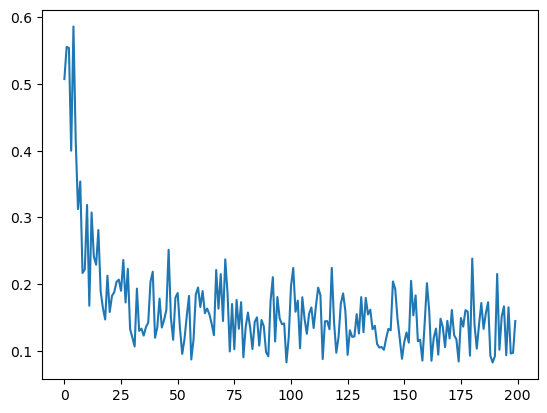

Task 4, Accuracy: 0.9885


In [4]:
for task_i in range(5):
    train_x, train_y, test_x, test_y = get_sMNIST(task_i, device)
    test_x_all.append(test_x)
    test_y_all.append(test_y)
    test_task_i_all.append(torch.ones((test_x.shape[0]), dtype=int) * task_i)

    # define current model
    if task_i == 0:
        current_model = MultiHeadVCLSplitMNIST(num_heads=1, random_initialize=True).to(device)
        current_model.set_prior(MultiHeadVCLSplitMNIST(num_heads=1, random_initialize=False).to(device))
    else:
        current_model = MultiHeadVCLSplitMNIST.new_from_prior(previous_model)
        # the following procedure allows us to keep the weights of the old heads the same
        # while re-initialising the new head and rest of the network (the shared weights)
        current_model.add_head(random_initialize=True)
        current_model.init_shared_weights(random_initialize=True)
    assert len(current_model.heads) == task_i + 1
    current_opt = torch.optim.Adam(current_model.parameters(), lr=0.001)

    if random_coreset:
        coreset_idx = np.random.choice(train_x.shape[0], coreset_size, False)
    else:
        coreset_idx = np.array(KCenter(coreset_size).fit_transform(train_x.cpu().detach().numpy()))
    train_idx = np.delete(np.arange(train_x.shape[0]), coreset_idx)
    new_coreset_x = train_x[coreset_idx]
    new_coreset_y = train_y[coreset_idx]
    new_coreset_task_mask = torch.ones((new_coreset_x.shape[0]), dtype=int) * task_i
    train_x = train_x[train_idx]
    train_y = train_y[train_idx]

    if coreset_x == None:
        coreset_x = new_coreset_x
        coreset_y = new_coreset_y
        coreset_task_mask = new_coreset_task_mask
    else:
        coreset_x = torch.cat([new_coreset_x, coreset_x])
        coreset_y = torch.cat([new_coreset_y, coreset_y])
        coreset_task_mask = torch.cat([new_coreset_task_mask, coreset_task_mask])
        # "For all the algorithms with coresets, we choose 40 examples from each task to include into the coresets"

    ELBO = []
    for epoch in tqdm(range(n_epochs)):
        ELBO_batch = []
        kl_batch = []
        log_pred_batch = []
        for batch in range(int(np.ceil(train_x.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            current_opt.zero_grad()
            elbo = current_model.calculate_ELBO(x=train_x[batch_idx0: batch_idx1], 
                                                y=train_y[batch_idx0: batch_idx1], 
                                                n_particles=1,
                                                task_i_mask=task_i,
                                                dataset_size=train_x.shape[0])
            elbo.backward()
            nn.utils.clip_grad_value_(current_model.parameters(), 5)
            current_opt.step()
            ELBO_batch.append(elbo.item())
        ELBO.append(np.mean(ELBO_batch))
    plt.plot(ELBO)
    plt.yscale("log")
    plt.show()

    test_x_tensor = torch.cat(test_x_all)
    test_y_tensor = torch.cat(test_y_all)
    test_task_i_mask_tensor = torch.cat(test_task_i_all)
    pred_y = []
    with torch.no_grad():
        for batch in range(int(np.ceil(test_x_tensor.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            pred_logit_samples = nn.Softmax(-1)(torch.stack(current_model.predict(test_x_tensor[batch_idx0:batch_idx1], test_task_i_mask_tensor[batch_idx0:batch_idx1], 100), 0)).mean(0)
            pred_y.append(pred_logit_samples.argmax(-1))
        pred_y = torch.cat(pred_y)
        acc = (pred_y == test_y_tensor).cpu().numpy().mean()
    print("Accuracy by the propagation model is %.4f"%acc)
        


    # calculate prediction model
    pred_model = MultiHeadVCLSplitMNIST.new_from_prior(current_model)
    pred_opt = torch.optim.Adam(pred_model.parameters(), lr=0.001)

    ELBO = []
    for epoch in tqdm(range(n_epochs)):
        ELBO_batch = []
        for batch in range(int(np.ceil(coreset_x.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            pred_opt.zero_grad()
            elbo = pred_model.calculate_ELBO(x=coreset_x[batch_idx0: batch_idx1], 
                                             y=coreset_y[batch_idx0: batch_idx1], 
                                             task_i_mask=coreset_task_mask[batch_idx0: batch_idx1],
                                             n_particles=1,
                                             dataset_size=coreset_x.shape[0])
            elbo.backward()
            nn.utils.clip_grad_value_(pred_model.parameters(), 5)
            pred_opt.step()
            ELBO_batch.append(elbo.item())
        ELBO.append(np.mean(ELBO_batch))
    plt.plot(ELBO)
    plt.show()

    test_x_tensor = torch.cat(test_x_all)
    test_y_tensor = torch.cat(test_y_all)
    test_task_i_mask_tensor = torch.cat(test_task_i_all)
    pred_y = []
    with torch.no_grad():
        for batch in range(int(np.ceil(test_x_tensor.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            pred_logit_samples = nn.Softmax(-1)(torch.stack(pred_model.predict(test_x_tensor[batch_idx0:batch_idx1], test_task_i_mask_tensor[batch_idx0:batch_idx1], 100), 0)).mean(0)
            pred_y.append(pred_logit_samples.argmax(-1))
        pred_y = torch.cat(pred_y)
        acc = (pred_y == test_y_tensor).cpu().numpy().mean()
    accuracies.append(acc)
    print("Task {:d}, Accuracy: {:.4f}".format(task_i, acc))
    previous_model = current_model

Accuracies: [1.0, 0.9975944190522011, 0.9928701707842812, 0.9925159037046276, 0.9885] Average: 0.994296098708222


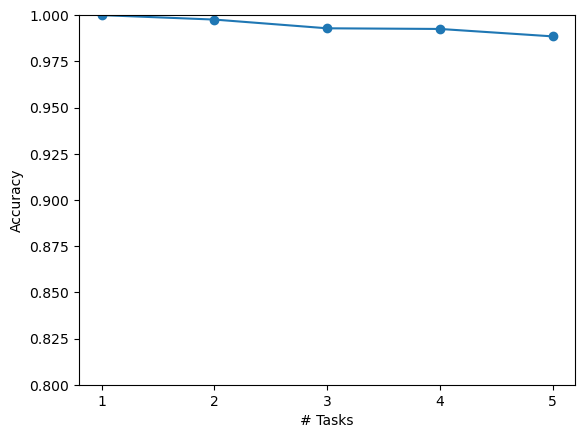

In [5]:
print("Accuracies:", accuracies, "Average:", np.mean(accuracies))
plt.plot(np.arange(1, 6), accuracies)
plt.scatter(np.arange(1, 6), accuracies)
plt.xticks(np.arange(1, 6))
plt.ylim(0.8, 1)
plt.xlabel("# Tasks")
plt.ylabel("Accuracy");